
## Analysis of Aggressiveness Index for multiple different autopilot.
Recalling that the index is define as follows:
$AggIn=\frac{avg(ESD(TP(t)))}{std(v_{desired}(t)-v_{real}(t))}$

Energy Spectral Density for descrete signal is given by $\bar{S}_{x x}(f)=\lim _{N \rightarrow \infty}(\Delta t)^2\left|\sum_{n=-N}^N x_n e^{-i 2 \pi f n \Delta t}\right|^2$

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft as fft
import scipy.signal as sgn
import re
import os

In [2]:
def esd(yt, fs):
    # computes ESD of a signal yt, keeping only positive frequencies! -> NOTE: this implies that total energy is halved
    N = len(yt)
    f = fft.rfftfreq(N, 1/fs)
    Sxx = np.square(1 / fs) *  np.square(np.abs(fft.rfft(yt)))
    
    return f, Sxx

In [3]:
def bode_plot(kp, ki, kd):
    num = [kd, kp, ki]
    den = [1, 0]
    sys = sgn.TransferFunction(num, den)
    w, mag, phase = sgn.bode(sys)
    plt.figure(figsize=(12,3))
    plt.title('Bode magnitude plot')
    plt.xlabel('Frequency [Hz]')
    plt.semilogx(w, mag)
    plt.figure(figsize=(12,3))
    plt.title('Bode phase plot')
    plt.xlabel('Frequency [Hz]')
    plt.semilogx(w, phase)
    plt.show()

In [29]:
def plot_signals(file, time_range=None):
    signals_df = pd.read_csv(file, sep=',', header=0)
    
    pattern = r"fUpdate=(\d+)Hz_PID=\(([\d\.]+),([\d\.]+),([\d\.]+)\)_dt=([\d\.]+)\.csv"
    match = re.search(pattern, file)
    
    dt = float(match.group(5))
    f_update = float(match.group(1))
    
    k_subsample = int(1 / (dt * f_update))
    
    x_t = np.array(signals_df['Time'], dtype=float)[::k_subsample]
    y_rv = np.array(signals_df['Velocity'], dtype=float)[::k_subsample]
    y_tv = np.array(signals_df['Target Velocity'], dtype=float)[::k_subsample]
    y_tp = np.array(signals_df['Throttle'], dtype=float)[::k_subsample]
    y_bp = np.array(signals_df['Brake'], dtype=float)[::k_subsample]
    
    plt.figure(figsize=(30,6))
    plt.title('Target Velocity vs. Real Velocity')
    plt.xlabel('Time [s]')
    plt.ylabel('Velocity [m/s]')
    plt.xlim(time_range)
    plt.plot(x_t, y_tv, label='Target velocity')
    plt.plot(x_t, y_rv, label='Real velocity')
    plt.legend(loc="lower right")
    plt.show()
    
    plt.figure(figsize=(30,6))
    plt.title('Throttle and brake')
    plt.xlabel('Time [s]')
    plt.ylabel('Relative throttle/brake')
    plt.plot(x_t, y_tp, label='Throttle')
    plt.plot(x_t, - y_bp, label='Brake')
    plt.xlim(time_range)
    plt.legend(loc="lower right")
    plt.show()

In [5]:
def plot_spectrum(file):
    signals_df = pd.read_csv(file, sep=',', header=0)
    pattern = r"fUpdate=(\d+)Hz_PID=\(([\d\.]+),([\d\.]+),([\d\.]+)\)_dt=([\d\.]+)\.csv"
    match = re.search(pattern, file)
    
    f_update = float(match.group(1))
    
    k_subsample = int(1 / (dt * f_update))
    
    x_t = np.array(signals_df['Time'], dtype=float)[::k_subsample]
    y_rv = np.array(signals_df['Velocity'], dtype=float)[::k_subsample]
    y_tv = np.array(signals_df['Target Velocity'], dtype=float)[::k_subsample]
    y_tp = np.array(signals_df['Throttle'], dtype=float)[::k_subsample]
    y_bp = np.array(signals_df['Brake'], dtype=float)[::k_subsample]    
    
    duration = x_t[-1] - x_t[0]
    fs = 10
    N = len(y_tv)
    yf = fft.rfft(y_tp)
    xf = fft.rfftfreq(N, 1/fs)

    plt.figure(figsize=(20,5))
    # plt.xlim(0, 100)
    # plt.ylim(0,0.01)
    plt.title("Spectrum of throttle")
    plt.xlabel("frequency [Hz]")
    plt.ylabel("relative pressure")
    plt.plot(xf, np.abs(yf) * 2 / (fs * duration))
    plt.show()

#### Import data retrieved by ```FTP_follower.ipynb```

In [9]:
dt = 0.005
f_update = 10

aggIn_values = []
mean_esd_values = []
std_err_values = []
KPs_values = []

for file in os.listdir('collectedData_slowAgent'):
    pattern = r"fUpdate=(\d+)Hz_PID=\(([\d\.]+),([\d\.]+),([\d\.]+)\)_dt=([\d\.]+)\.csv"
    match = re.search(pattern, file)

    if match and int(match.group(1)) == f_update and float(match.group(5)) == dt:
        signals_df = pd.read_csv('collectedData_slowAgent/' + file, sep=',', header=0)
        
        k_subsample = int(1 / (dt * f_update))
        
        x_t = np.array(signals_df['Time'], dtype=float)[::k_subsample]
        y_rv = np.array(signals_df['Velocity'], dtype=float)[::k_subsample]
        y_tv = np.array(signals_df['Target Velocity'], dtype=float)[::k_subsample]
        y_tp = np.array(signals_df['Throttle'], dtype=float)[::k_subsample]
        y_bp = np.array(signals_df['Brake'], dtype=float)[::k_subsample]

        
        f, Sxx = esd(y_tp, f_update)
        aggIn_values.append(np.mean(Sxx) / np.std(y_tv - y_rv))
        std_err_values.append(np.std(y_tv - y_rv))
        mean_esd_values.append(np.mean(Sxx))
        KPs_values.append(float(match.group(2)))
    else:
        print(file + " doesn't match")


test_FTPfollowing_KP=0.08_KI=0.01_KD=0.01_dt=0.005.csv doesn't match
test_FTPfollowing_KP=0.1_KI=0.01_KD=0.01_dt=0.005.csv doesn't match


In [10]:
KPs_values

[0.001,
 0.002,
 0.003,
 0.005,
 0.0075,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1,
 0.11,
 0.12,
 0.13,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.6,
 0.7,
 0.8,
 0.9,
 1.0]

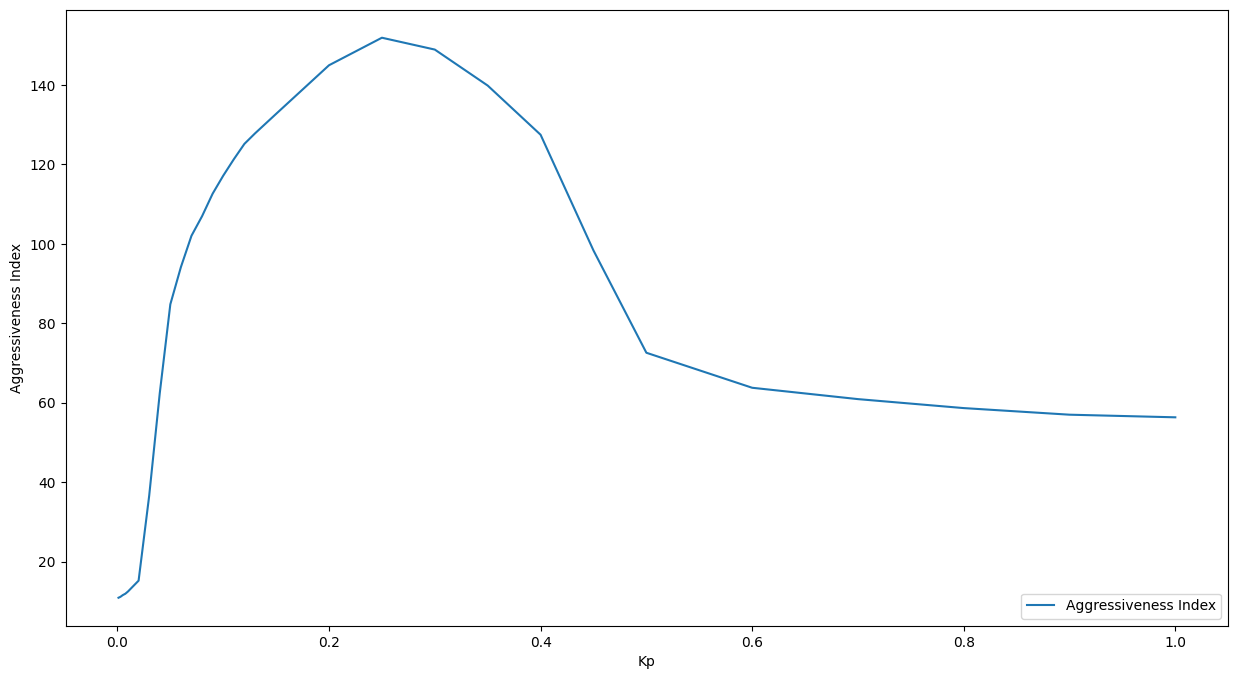

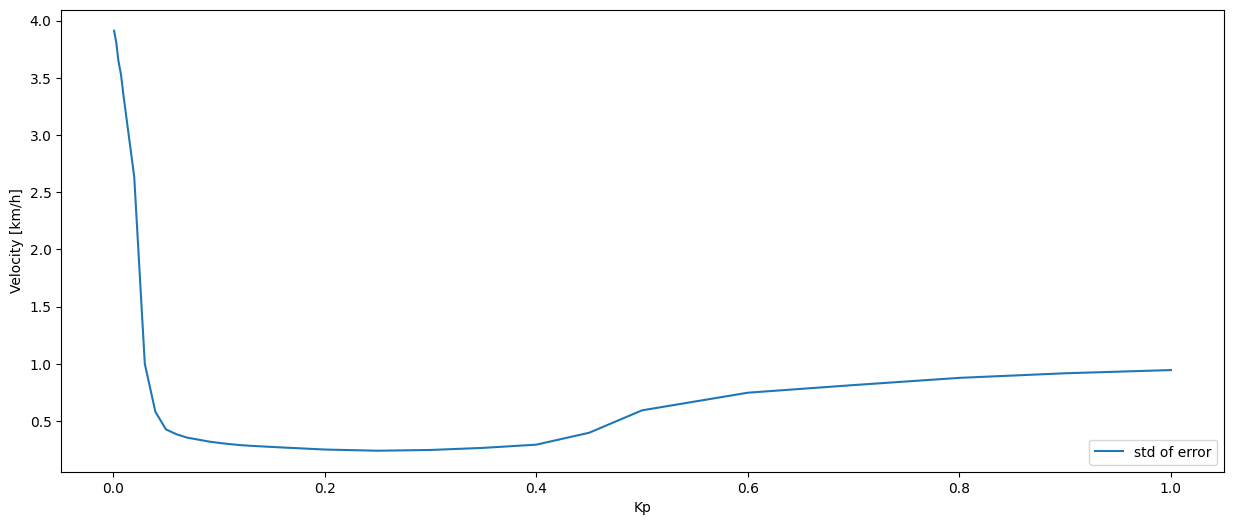

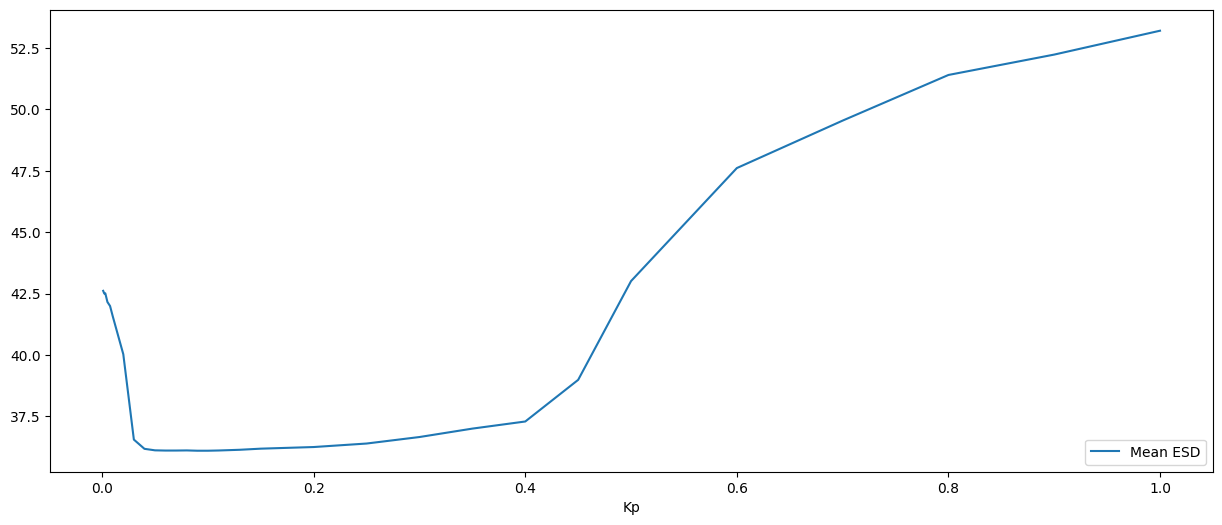

In [7]:
plt.figure(figsize=(15,8))
plt.plot(KPs_values, aggIn_values, label='Aggressiveness Index')
plt.legend(loc="lower right")
plt.xlabel('Kp')
plt.ylabel('Aggressiveness Index')
plt.show()

plt.figure(figsize=(15,6))
plt.plot(KPs_values, std_err_values, label='std of error')
plt.legend(loc="lower right")
plt.xlabel('Kp')
plt.ylabel('Velocity [km/h]')
plt.show()

plt.figure(figsize=(15,6))
plt.plot(KPs_values, mean_esd_values, label='Mean ESD')
plt.legend(loc="lower right")
plt.xlabel('Kp')
plt.show()

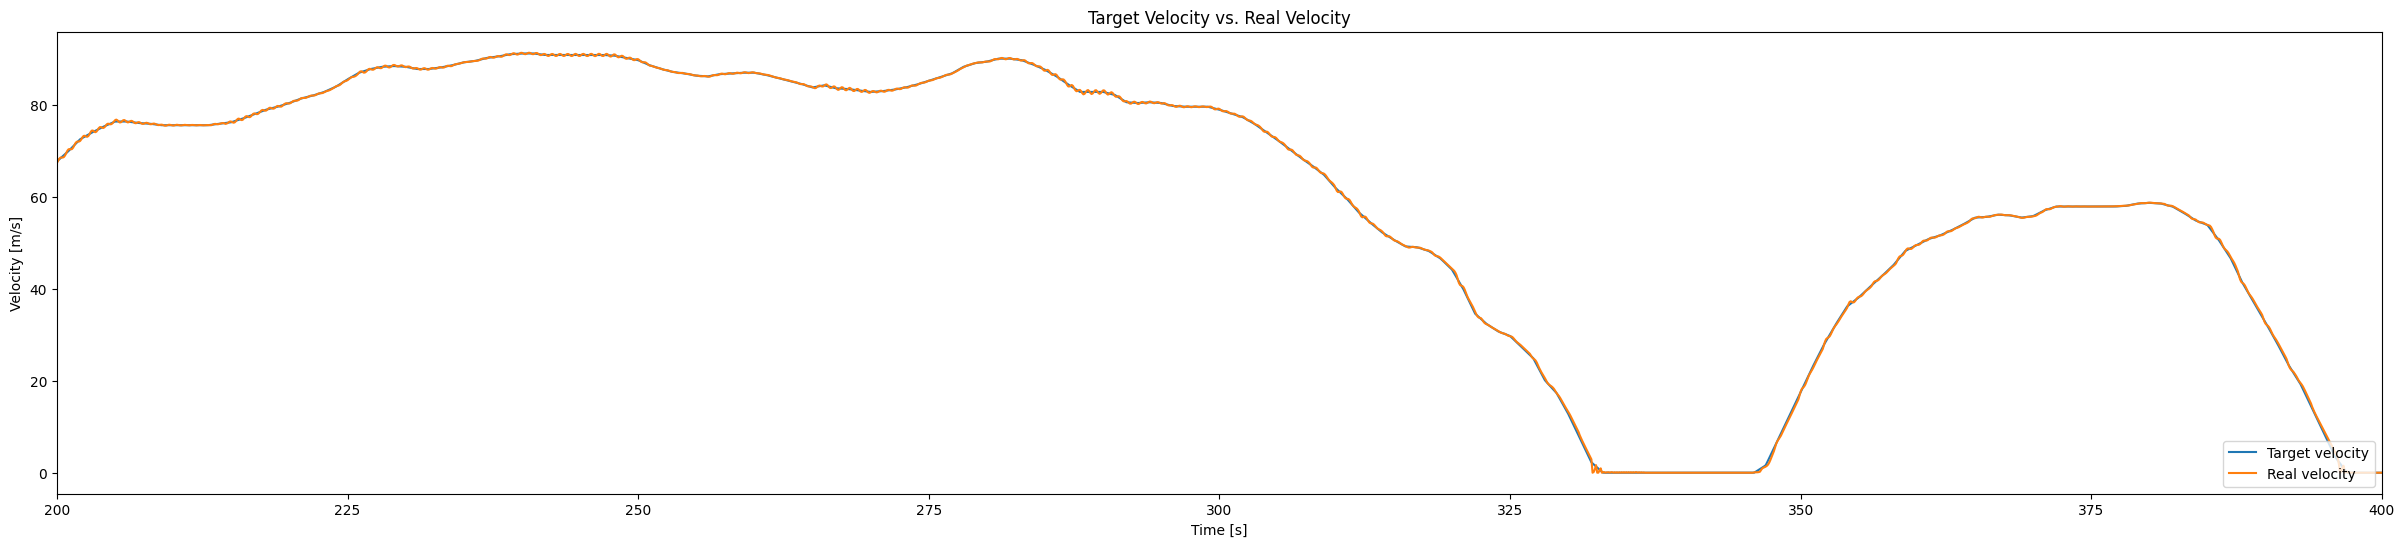

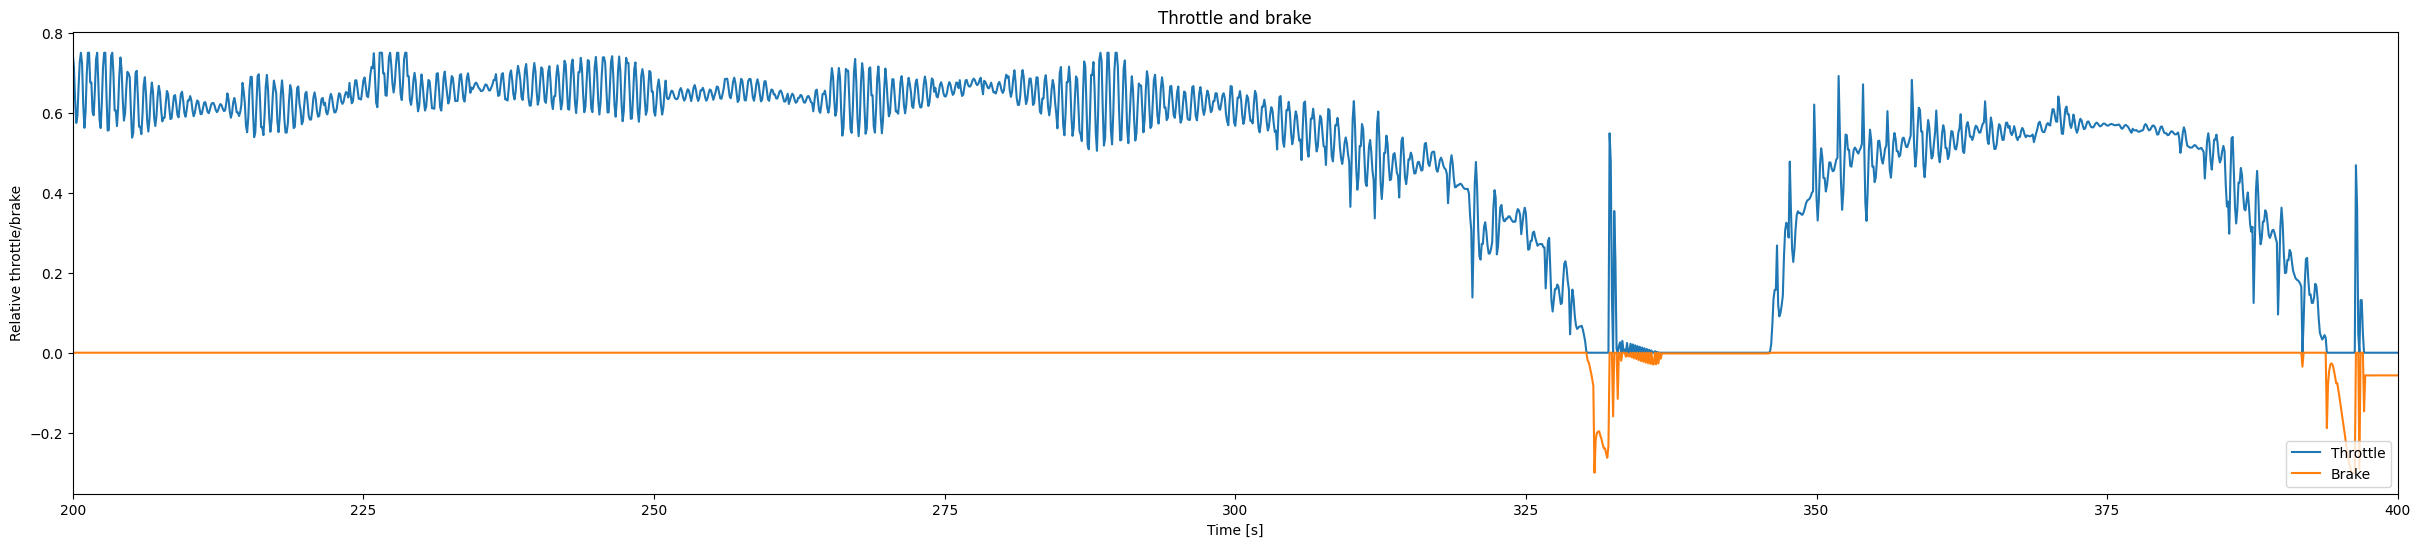

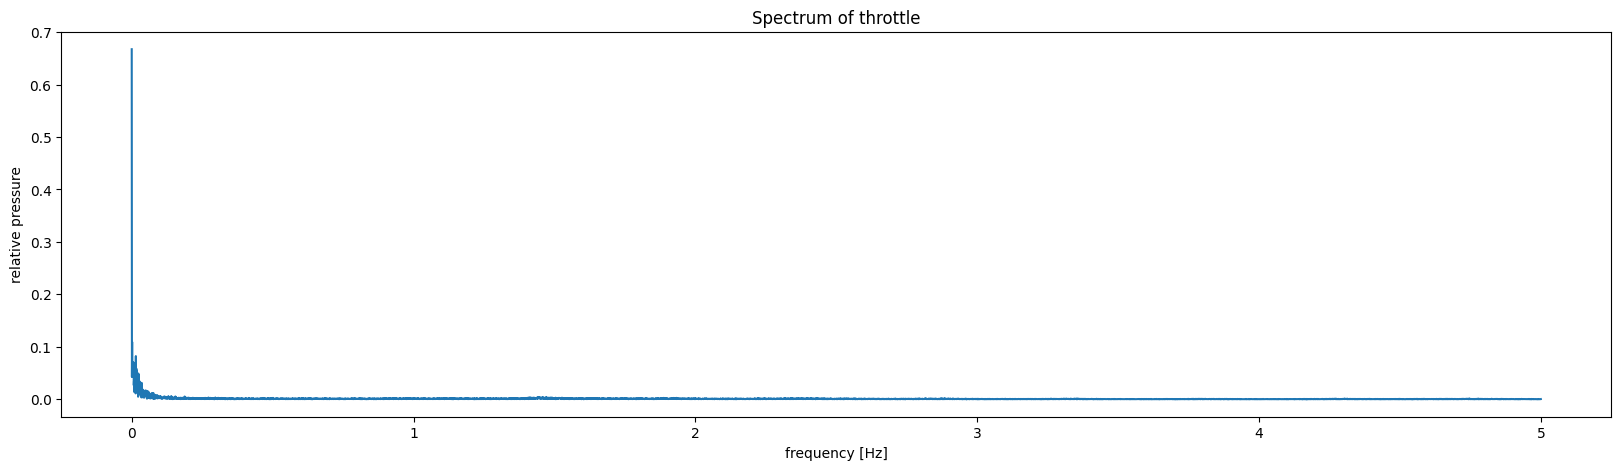

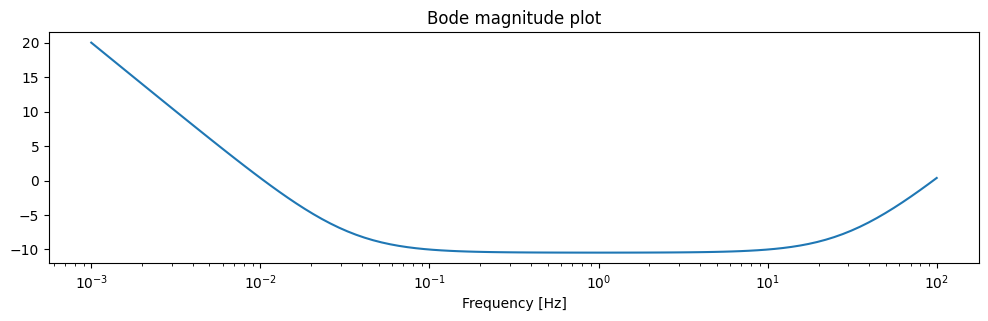

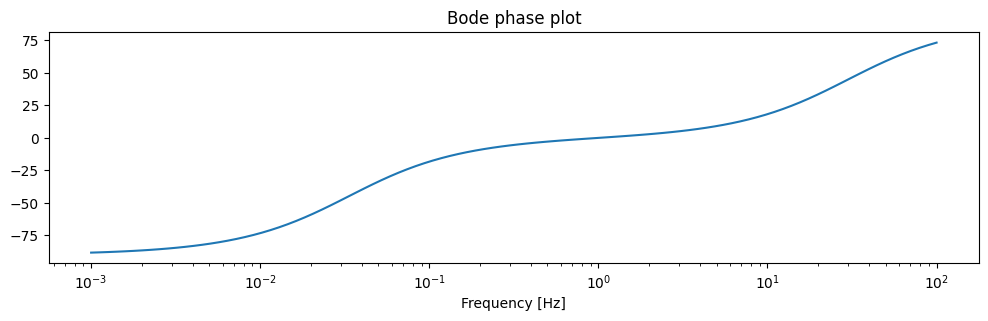

In [30]:
examined_file = 'collectedData_slowAgent/FTPfollowing_slowAgent_fUpdate=10Hz_PID=(0.3,0.01,0.01)_dt=0.005.csv'
plot_signals(examined_file, time_range=(200, 400))
plot_spectrum(examined_file)

pattern = r"fUpdate=(\d+)Hz_PID=\(([\d\.]+),([\d\.]+),([\d\.]+)\)_dt=([\d\.]+)\.csv"
match = re.search(pattern, examined_file)
if match:
    bode_plot(float(match.group(2)), float(match.group(3)), float(match.group(4)))